In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

from tifffile import imread

datapath = Path.cwd().parent / "data"
tracking_path = datapath / "interim" / "tracking"


In [3]:
from src.utils import tracklet_from_path, ap_axis_position, detect_nuclear_cycle, get_tracklet_tree

root = "embryo006"
results_path = Path.cwd().parent / "results" / "lineages" / root
spots, edges, tracks, tracklets = tracklet_from_path(tracking_path, root, t_delta=1/4)
color_img = imread(tracking_path /  f"{root}_vis.tif")
label_img = imread(tracking_path /  f"{root}_label_img.tif")

### Confirm Movie-Specific Parameters
# anterior-posterior axis endpoints 
x_a, y_a = 255/2, 63/2
x_p, y_p = 2073/2, 2550/2

n_divisions = 4

spots, tracklets = ap_axis_position(spots, tracklets, (x_a, y_a), (x_p, y_p))
peaks, tracklets = detect_nuclear_cycle(tracklets, n_divisions + 1)

spots["label_img_id"] = label_img[spots["FRAME"], spots["POSITION_Y"].astype(int), spots["POSITION_X"].astype(int)]

def jitter(values, amt=0.05):
    return values + np.random.normal(0,amt,values.shape)

76756it [00:00, 181887.21it/s]
C:\Users\Harrison\.conda\envs\linajea\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Harrison\.conda\envs\linajea\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Harrison\.conda\envs\linajea\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


In [4]:
from skimage.morphology import convex_hull_image
from scipy.spatial.distance import cdist
from PIL import Image

# visualize nuclei domains

# frame of interest
k = 140

# get convex hull of label image
convex_hull = convex_hull_image(label_img[k])
print(convex_hull.shape)

# get nearest centroid in spots to each pixel
centroids = spots[spots["FRAME"] == k][["POSITION_Y", "POSITION_X"]].values
centroids.put(0, np.array([0, 0]))
yx = np.meshgrid(np.arange(label_img.shape[1]), np.arange(label_img.shape[2]))
yx = np.stack([yx[1].flatten(), yx[0].flatten()], axis=1)

nearest_centroid = np.argmin(cdist(yx, centroids), axis=1).reshape(label_img.shape[1], label_img.shape[2])*convex_hull

# map label image centroid id to color image color
cmap = np.array([color_img[k][*centroid] for centroid in np.array(centroids, dtype=int)])

color_centroids = cmap[np.array(nearest_centroid, dtype=int)]

# create an image with the color centroids
color_centroids_img = Image.fromarray(color_centroids)
color_centroids_img.save(results_path / "color_centroids.png")

(1360, 1360)


spots Index(['LABEL', 'ID', 'TRACK_ID', 'QUALITY', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'POSITION_T', 'FRAME', 'RADIUS', 'VISIBILITY',
       'MANUAL_SPOT_COLOR', 'MEAN_INTENSITY_CH1', 'MEDIAN_INTENSITY_CH1',
       'MIN_INTENSITY_CH1', 'MAX_INTENSITY_CH1', 'TOTAL_INTENSITY_CH1',
       'STD_INTENSITY_CH1', 'CONTRAST_CH1', 'SNR_CH1', 'ELLIPSE_X0',
       'ELLIPSE_Y0', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_ASPECTRATIO', 'AREA', 'PERIMETER', 'CIRCULARITY', 'SOLIDITY',
       'SHAPE_INDEX', 'source_count', 'target_count', 'TRACKLET_ID', 'time',
       'ap_position', 'edge_position', 'label_img_id'],
      dtype='object')
edges Index(['LABEL', 'TRACK_ID', 'SPOT_SOURCE_ID', 'SPOT_TARGET_ID', 'LINK_COST',
       'DIRECTIONAL_CHANGE_RATE', 'SPEED', 'DISPLACEMENT', 'EDGE_TIME',
       'EDGE_X_LOCATION', 'EDGE_Y_LOCATION', 'EDGE_Z_LOCATION',
       'MANUAL_EDGE_COLOR'],
      dtype='object')
tracks Index(['LABEL', 'TRACK_INDEX', 'TRACK_ID', 'NUMBER_SPOTS

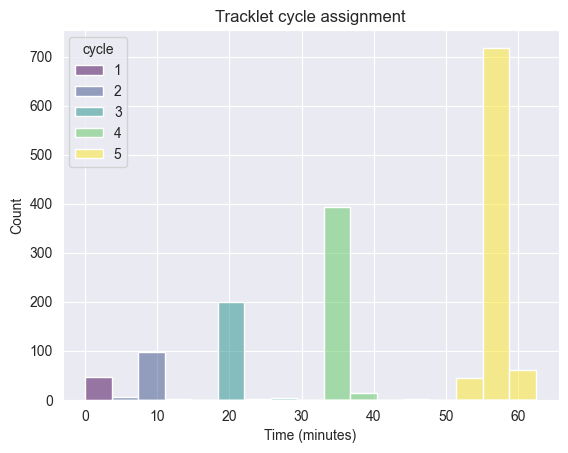

In [5]:
print("spots", spots.columns)
print("edges", edges.columns)
print("tracks", tracks.columns)
print("tracklets", tracklets.columns)

# sns.histplot(tracklets, x="start", y="length", palette="viridis")
# sns.kdeplot(tracklets, x="start", y="length", levels=5, fill=True)

normal_start = tracklets[np.abs(tracklets["cycle_start_deviation"]) < 2.0]

early_end = normal_start[normal_start["cycle_end_deviation"] < 2.0]
late_end = normal_start[normal_start["cycle_end_deviation"] > 2.0]

# sns.scatterplot(x=jitter(late_end.cycle), y=jitter(late_end["cycle_end_deviation"], 0.5), hue=late_end.cycle, palette="viridis")

# plt.title("tracklet assigned cycle")

sns.histplot(tracklets, x="start_time", hue="cycle", palette="viridis")

plt.title("Tracklet cycle assignment")
plt.xlabel("Time (minutes)")
plt.savefig(results_path / "tracklet_cycle_assignment.png")
plt.show()

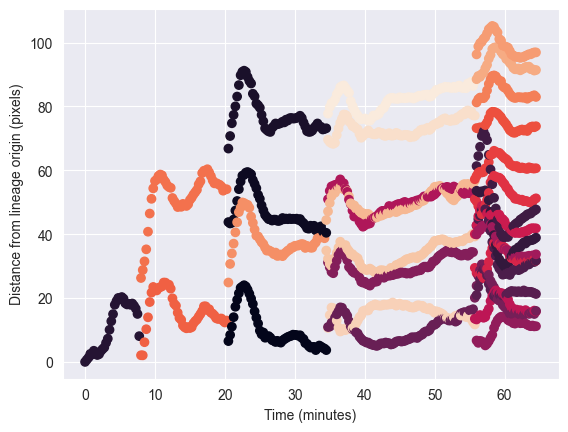

In [6]:
# visualize a single lineage tree
track = spots[spots["TRACK_ID"] == spots["TRACK_ID"].unique()[6]]
track = track.sort_values(by="FRAME")
distance_from_origin = np.sqrt((track["POSITION_X"] - track["POSITION_X"].iloc[0])**2 + (track["POSITION_Y"] - track["POSITION_Y"].iloc[0])**2)

plt.scatter(track["time"], distance_from_origin, c=track["TRACKLET_ID"])

plt.xlabel("Time (minutes)")
plt.ylabel("Distance from lineage origin (pixels)")

plt.savefig(results_path / "lineage_distance_from_origin.png")

plt.show()

TRACK_ID
0        1
4        6
5        7
7        9
11      14
15      18
16      19
18      21
19      23
20      24
21      25
22      26
25      29
29      34
30      35
32      37
33      38
34      39
36      42
40      46
41      47
44      51
45      52
46      53
50      58
52      60
56      64
58      67
61      70
62      71
64      73
65      74
70      80
73      83
75      86
76      87
77      88
78      89
79      90
81      92
82      94
83      95
84      96
85      97
86      98
92     105
96     109
103    117
104    118
109    124
112    127
118    134
128    145
135    153
Name: label_img_id, dtype: uint8
[52, 56, 73, 64, 75, 85, 96, 86, 4, 22, 32, 20, 16, 70, 45, 33]


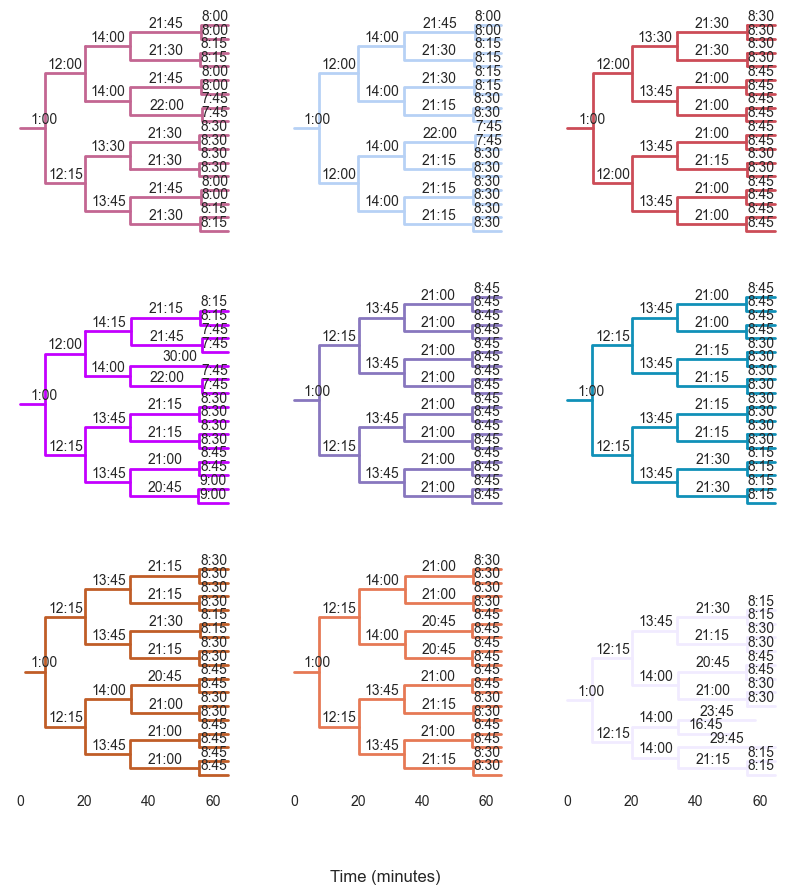

In [10]:
from src.utils import get_tracklet_tree, visualize_tracklet_tree

def plot_tracklet_trees(track_ids,  fig, axes):
    for track_id,  ax in zip(track_ids, axes.flatten()):
        tree = get_tracklet_tree(tracklets[tracklets["track_id"] == track_id])
        
        # get track color
        spot = spots[spots["TRACK_ID"] == track_id]
        spot_x, spot_y, spot_frame = spot["POSITION_X"].iloc[0], spot["POSITION_Y"].iloc[0], spot["FRAME"].iloc[0]
       
        color = color_img[int(spot_frame)][int(spot_y)][int(spot_x)]
        color_rgb = f"#{color[0]:02x}{color[1]:02x}{color[2]:02x}"
        
        label = label_img[spot_frame][int(spot_y)][int(spot_x)]
        
        # ax.set_title(f"track {track_id}, label {label}")
        ax.set_facecolor("w")
            
        visualize_tracklet_tree(tree, ax, c=color_rgb)
    
    fig.supxlabel("Time (minutes)")
    
    return fig, axes

### manually selected trees
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex="all", sharey="all")

# map label_img_id to track_id
label_img_id = spots.groupby("TRACK_ID")["label_img_id"].first()
label_img_id = label_img_id[label_img_id != 0]

print(label_img_id)

# trees_of_interest_001 = [84, 96, 66, 115, 102, 134, 38, 24, 19, 43, 116, 41, 14, 31, 37, 50, 62, 42, 39, 36, 93, 76, 47, 73, 89, 106, 82, ]
trees_of_interest = [60, 64, 83, 73, 86, 97, 109, 98, 6, 26, 37, 24, 19, 80, 52, 38]
track_id = [label_img_id[label_img_id == k].index[0] for k in trees_of_interest]
print(track_id)

fig, axes = plot_tracklet_trees(track_id, fig, axes)

plt.savefig(results_path / "tracklet_trees_of_interest.png")
plt.show()

70     83
99    117
66     77
42     48
26     29
12     12
82     97
92    108
9       9
Name: TRACK_ID, dtype: int64


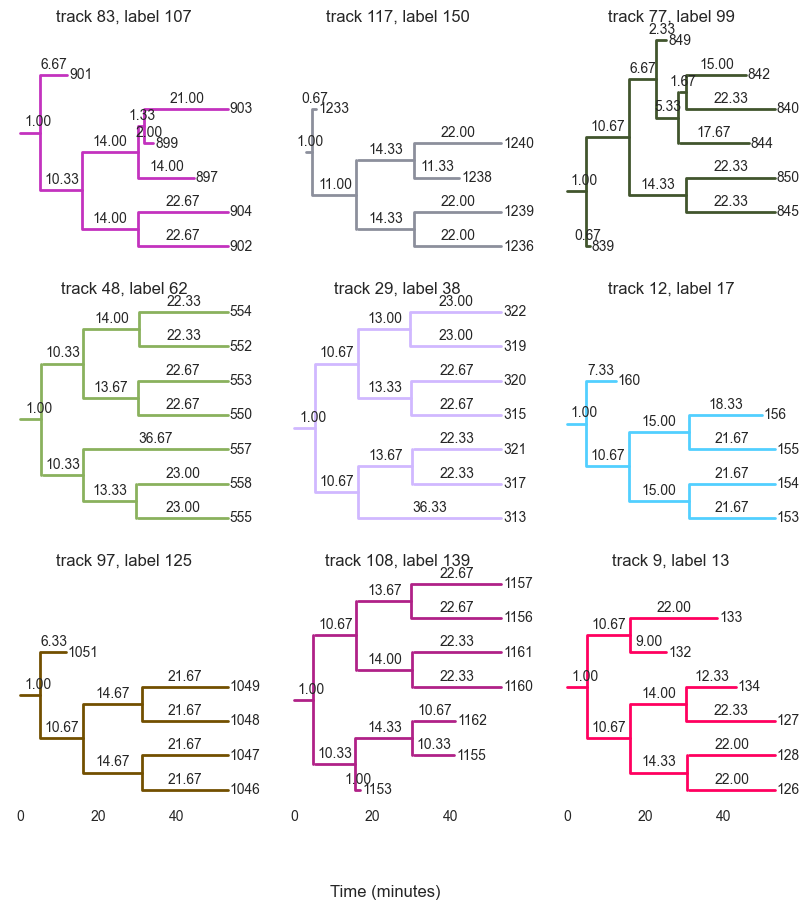

In [8]:
### Trees with 4-6 splits
fig, axes = plt.subplots(3, 3, figsize=(10, 10), sharex="all", sharey="all")

split_track_ids = tracks[tracks["NUMBER_SPLITS"].between(4, 6)]["TRACK_ID"].sample(9)

print(split_track_ids)

fig, axes = plot_tracklet_trees(split_track_ids, fig, axes)

plt.savefig(results_path / "tracklet_short_trees.png")
plt.show()

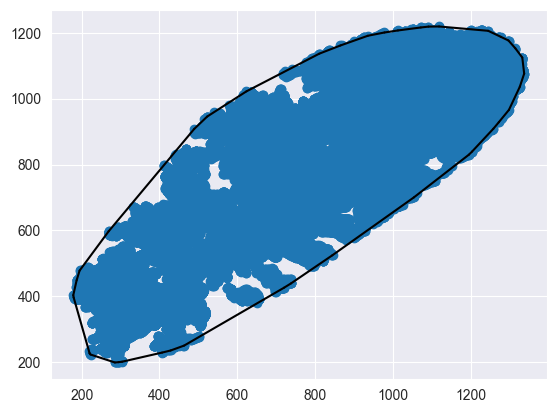

In [9]:
from scipy.spatial import ConvexHull

def plot_convex_hull(spots, tracklet_id):
    points = spots[["POSITION_X", "POSITION_Y"]].values
    hull = ConvexHull(points)
    
    plt.plot(points[:,0], points[:,1], 'o')
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')
        
plot_convex_hull(spots, 6)